In [1]:
import numpy as np
import pandas as pd
import cymetric as cym
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../../transition-scenarios/scripts/')
import transition_metrics as tm

## Looking at simple toy problem with d3ploy
Toy problem has LWRs deployed using cycamore:DeployInst, then the Advanced Reactors 
are deployed using d3ploy.demand_driven_inst. The defined energy demand for the scenario is 
np.heaviside(t-50, 0.5)*300, or a demand of 0 until time step 500, then a demand of 300. 

LWRs are deployed:
* 1 at t=1
* 2 at t=100
* 1 at t=200

Each LWR supplies 100 MWe of power, each AdvancedReactor supplies 75 MWe of power. LWRs
have a lifetime of 240 timesteps, cycle time of 18, and refule of 1 step. 
AdvancedReactors have a lifetime of 140 timesteps, a cycle length of 24 
months, and a refueling of 1 step. 
The simulation runs for 1000 time steps.


In [3]:
def get_lwr_energy(filename, advanced_rx):
    evaler = tm.get_metrics(filename)
    agents = evaler.eval('Agents')
    energy = evaler.eval('MonthlyElectricityGeneratedByAgent')
    #energy = cym.tools.add_missing_time_step(energy, evaler.eval('TimeList'))
    merged_df = pd.merge(energy, agents, on=['SimId', 'AgentId'])
    lwr_energy = merged_df.loc[merged_df['Prototype'] != advanced_rx]
    lwr_energy = lwr_energy.groupby(['Month']).Energy.sum().reset_index()
    lwr_energy['Energy'] = lwr_energy['Energy'] / 1000
    return lwr_energy

def get_prototype_energy(filename, advanced_rx):
    evaler = tm.get_metrics(filename)
    agents = evaler.eval('Agents')
    energy = evaler.eval('MonthlyElectricityGeneratedByAgent')
    merged_df = pd.merge(energy, agents, on=['SimId', 'AgentId'])
    prototype_energy = merged_df.loc[merged_df['Prototype'] == advanced_rx]
    prototype_energy = prototype_energy.groupby(
        ['Month']).Energy.sum().reset_index()
    prototype_energy['Energy'] = prototype_energy['Energy'] / 1000
    return prototype_energy

In [51]:
calc_methods = ["ma", "arma", "arch","poly",
                "exp_smoothing", "holt_winters", "fft", "sw_seasonal"]
lines = ['dashed','dashdot']

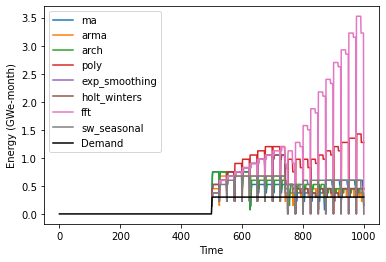

In [26]:
# Compare algorithms when DeployInst isn't used
for calc in calc_methods:
    out_file = "d3ploy_" + calc + ".sqlite"
    energy = tm.get_monthly_electricity(out_file)
    plt.plot((energy['Year']-1965)*12, energy['Energy'], label=calc)
t = np.linspace(0, 999, 1000)
plt.plot(t, np.heaviside(t-500,0.5)*0.3, 'k', label='Demand')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy (GWe-month)')
plt.savefig('d3ploy_algorithm_compare.png')

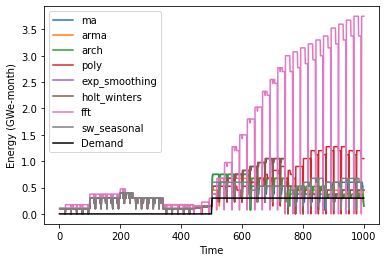

In [27]:
# Compare algorithms when DeployInst is used
for calc in calc_methods:
    out_file = "d3ploy_" + calc + "_DeployInst.sqlite"
    energy = tm.get_monthly_electricity(out_file)
    plt.plot((energy['Year']-1965)*12, energy['Energy'], label=calc)
t = np.linspace(0, 999, 1000)
plt.plot(t, np.heaviside(t-500,0.5)*0.3, 'k', label='Demand')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy (GWe-month)')
plt.savefig('d3ploy_algorithm_DI_compare.png')

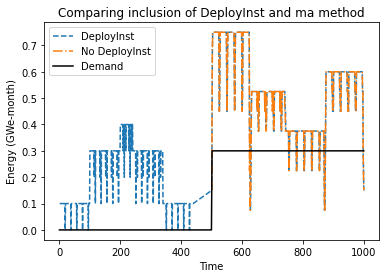

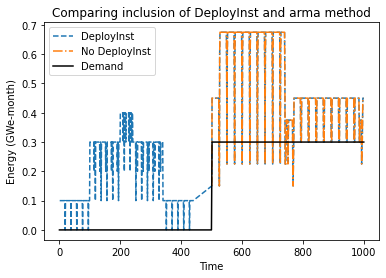

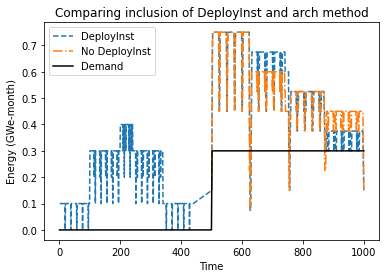

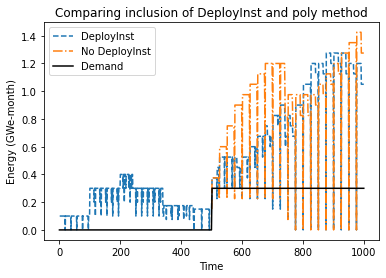

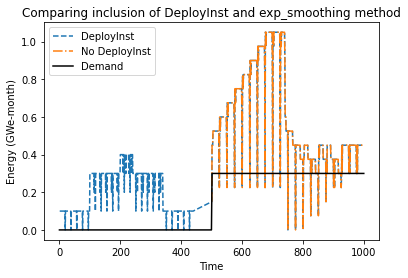

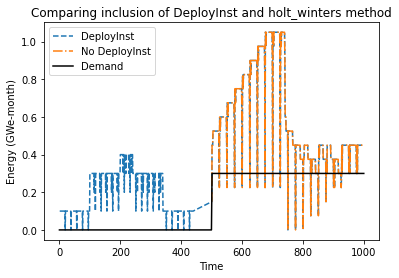

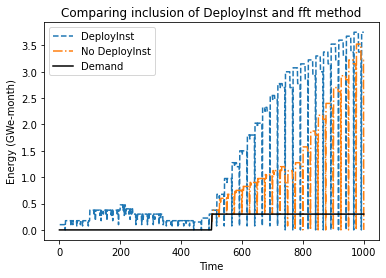

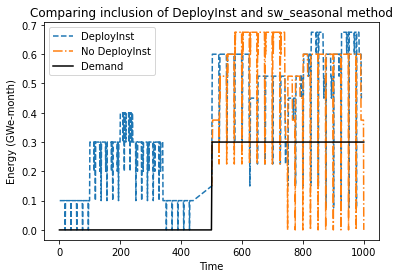

In [52]:
#Comparing total energy generated to including a DeployInst
for calc in calc_methods:
    plt.figure()
    outfiles = ["d3ploy_" +calc +"_DeployInst.sqlite", "d3ploy_"+calc+".sqlite"]
    for file_index, file in enumerate(outfiles):
        energy = tm.get_monthly_electricity(file)
        plt.plot((energy['Year']-1965)*12, energy['Energy'], linestyle=lines[file_index])
    t = np.linspace(0, 999, 1000)
    plt.plot(t, np.heaviside(t-500,0.5)*0.3, 'k')
    plt.legend(['DeployInst', 'No DeployInst', 'Demand'])
    plt.xlabel('Time')
    plt.ylabel('Energy (GWe-month)')
    plt.title(f'Comparing inclusion of DeployInst and {calc} method')
#plt.savefig('d3ploy_deployinst_compare.png') 

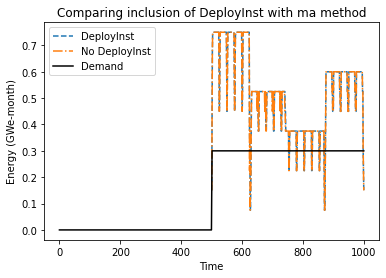

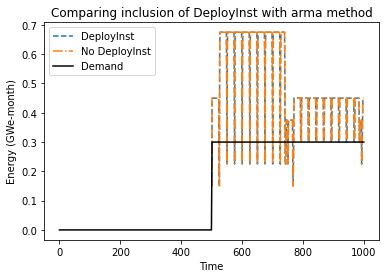

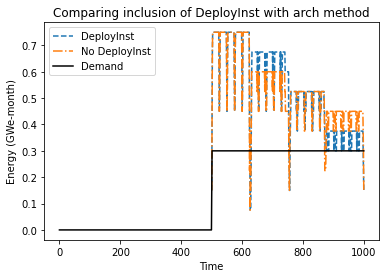

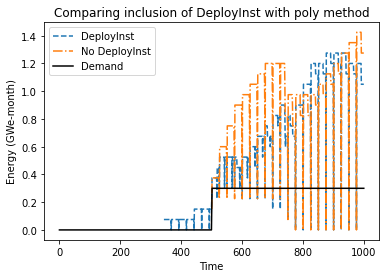

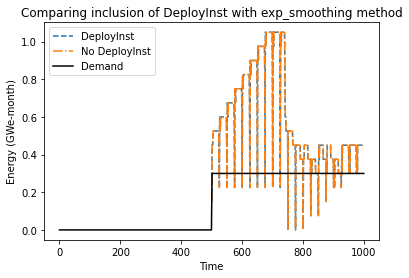

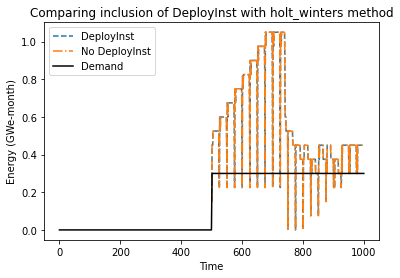

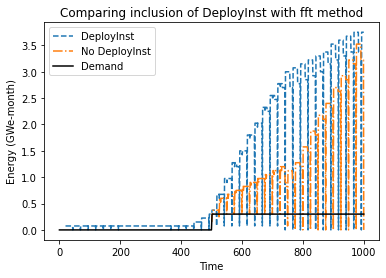

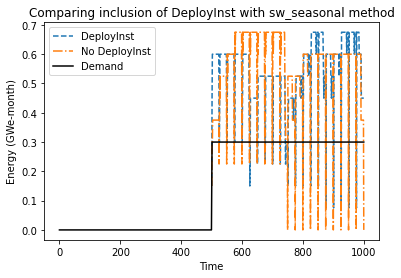

In [53]:
#Comparing energy generated from ARs based on inclusion of a DeployInst
for calc in calc_methods:
    plt.figure()
    outfiles = ["d3ploy_" +calc+"_DeployInst.sqlite", "d3ploy_"+calc+".sqlite"]
    for file_index, file in enumerate(outfiles):
        AR_energy = get_prototype_energy(file, 'AdvancedReactor')            
        plt.plot(AR_energy['Month'], AR_energy['Energy'], linestyle=lines[file_index])
    t = np.linspace(0, 999, 1000)
    plt.plot(t, np.heaviside(t-500,0.5)*0.3, 'k')
    plt.legend(['DeployInst', 'No DeployInst', 'Demand'])
    plt.xlabel('Time')
    plt.ylabel('Energy (GWe-month)')
    plt.title(f'Comparing inclusion of DeployInst with {calc} method')
#plt.savefig('d3ploy_DI_compare_AREnergy.png')

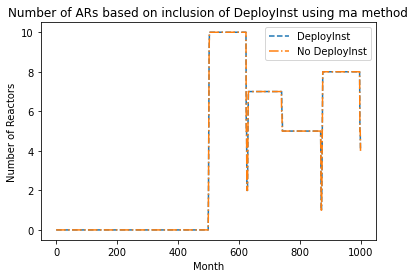

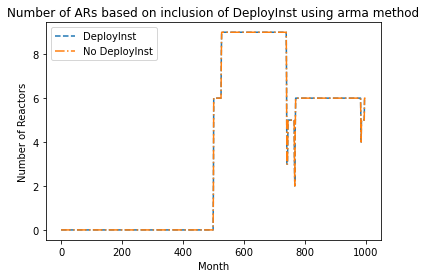

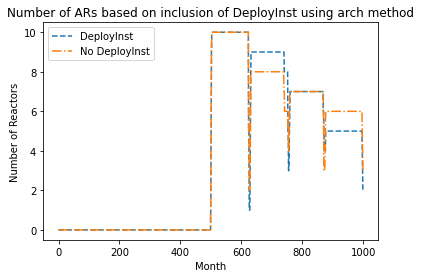

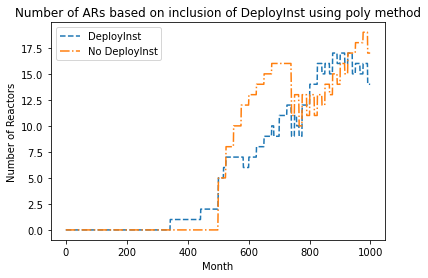

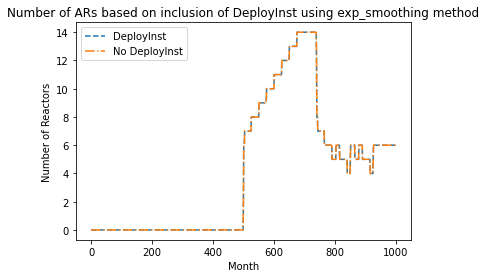

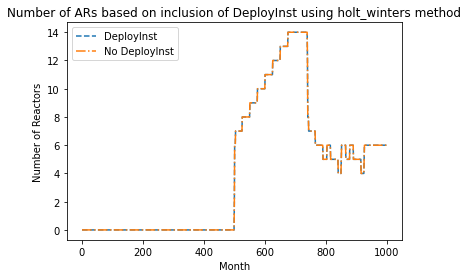

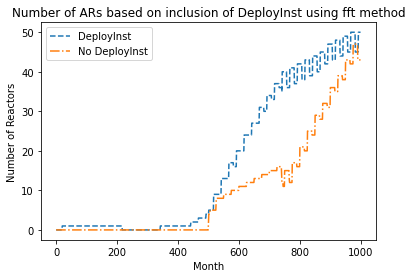

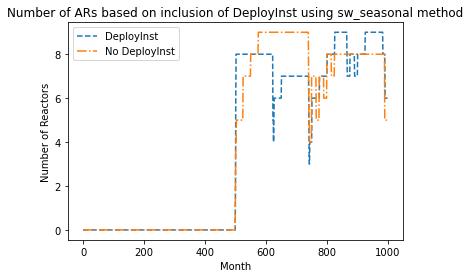

In [54]:
# Comparing number of ARs built based on inclusion of DeployInst
non_lwr = ['source', 'sink', 'AdvancedReactor', 
               'LWRDeployment', 'sink_source_facilities',
               'SingleRegion', 'source_inst']
for calc in calc_methods:
    plt.figure()
    outfiles = ["d3ploy_" +calc+"_DeployInst.sqlite", "d3ploy_"+calc+".sqlite"]
    for file_index, file in enumerate(outfiles):
        AR_numbers = tm.prototype_totals(file, non_lwr, ['AdvancedReactor'])
        plt.plot(AR_numbers['Time'], AR_numbers['AdvancedReactor_total'], linestyle=lines[file_index])
    plt.legend(['DeployInst', 'No DeployInst'])
    plt.xlabel('Month')
    plt.ylabel('Number of Reactors')
    plt.title(f'Number of ARs based on inclusion of DeployInst using {calc} method')
    #plt.savefig('d3ploy_DI_compare.png')

## Comparing d3ploy to ManagerInst

In [ ]:
calc_methods = ["ma", "arma", "arch","poly",
                "exp_smoothing", "holt_winters", "fft", "sw_seasonal"]
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'Xe-100', ]

In [ ]:
for calc in cal_methods:
    out_file = f"xe100_{calc}.sqlite"
    reactors = tm.prototype_totals(out_file, non_lwr, ['Xe-100'])
    plt.plot(reactors['Time'], reactors['Xe-100_total'], label='d3ploy')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Reactors')

In [19]:
manager_inst_file = "../../transition-scenarios/input/haleu/outputs/xe100_nogrowth.sqlite"
d3ploy_file = "xe100_d3ploy.sqlite"

In [21]:

manager_inst_reactors = tm.prototype_totals(manager_inst_file, non_lwr, ['Xe-100'])
d3ploy_reactors = tm.prototype_totals(d3ploy_file, non_lwr, ['Xe-100'])

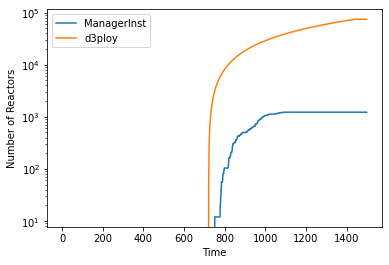

In [22]:
plt.plot(manager_inst_reactors['Time'], manager_inst_reactors['Xe-100_total'], label='ManagerInst')
plt.plot(d3ploy_reactors['Time'], d3ploy_reactors['Xe-100_total'], label='d3ploy')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Reactors')
plt.yscale('log')
plt.savefig('s3_reactor_comparison.png')

In [19]:
d3ploy_energy['Energy'].max()

3561.2625

In [ ]:
#manager_inst_energy = tm.get_annual_electricity(manager_inst_file)
d3ploy_energy = tm.get_annual_electricity(d3ploy_file)

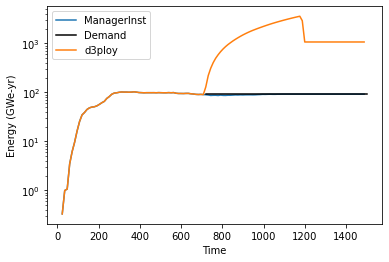

In [17]:
plt.plot((manager_inst_energy['Year']-1965)*12, manager_inst_energy['Energy'], label='ManagerInst')
plt.plot(np.linspace(721, 1500, 50), np.repeat(91.818, 50),'k', label='Demand')
plt.plot((d3ploy_energy['Year']-1965)*12, d3ploy_energy['Energy'], label='d3ploy')
plt.legend()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Energy (GWe-yr)')
plt.savefig('s3_energy_comparison.png')

## Inputs from d3ploy repo

In [ ]:
data = pd.read_csv